In [1]:
import cv2
import numpy as np
from pdf2image import convert_from_path
import PIL
import easyocr
import os
import copy

import matplotlib.pyplot as plt
from PIL import ImageDraw, ImageFont, Image
from dotenv import load_dotenv, find_dotenv
from openai import AzureOpenAI
import os
import json

import base64
from mimetypes import guess_type

In [2]:
# turn pdf to jpg
path = "C:\\Users\\jimmy\\Desktop\\sinotech2\\data\\pdf\\SheetPile\\Q881SE1820-配置1.pdf"
images = convert_from_path(path, dpi =210)
cv2_img = cv2.cvtColor(np.asarray(images[0]),cv2.COLOR_RGB2BGR)
img_gray = cv2.cvtColor(cv2_img, cv2.COLOR_BGR2GRAY)
_, img_th = cv2.threshold (img_gray, 240, 255, 0)
img = cv2.GaussianBlur(img_th, (5, 5), 0)

cv2.imwrite("plan_ref.jpg", img)

True

The shape of the reference image is (4912, 6954, 3)


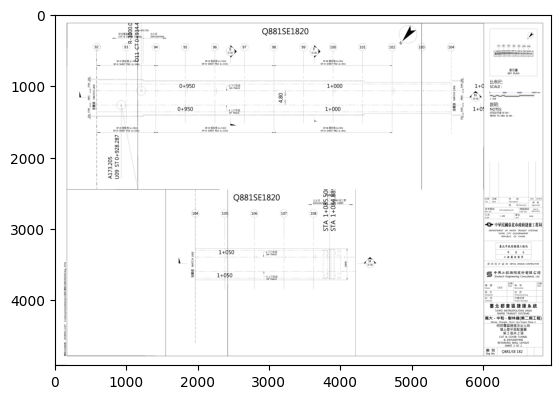

In [26]:
# 求比例尺
ref_img = cv2.imread("plan_ref.jpg")
print(f'The shape of the reference image is {ref_img.shape}')
# draw a red line on the reference image\
drw_img = copy.deepcopy(ref_img)
cv2.line(drw_img, (6080, 1100), (6700, 1100), (0, 0, 255), 1)
cv2.imwrite("plan_ref_draw.jpg", drw_img)
plt.imshow(drw_img)

## 直接問chatgpt 不行

In [27]:
load_dotenv(find_dotenv())

api_base = os.getenv("GPT4V_ENDPOINT")
api_key= os.getenv("AZURE_OPENAI_API_KEY")
deployment_name = 'gpt4-vision'
api_version = '2023-12-01-preview'

client = AzureOpenAI(
    api_key=api_key,  
    api_version=api_version,
    base_url=f"{api_base}/openai/deployments/{deployment_name}/extensions",
)

# Function to encode a local image into data URL 
def local_image_to_data_url(image_path):
    # Guess the MIME type of the image based on the file extension
    mime_type, _ = guess_type(image_path)
    if mime_type is None:
        mime_type = 'application/octet-stream'  # Default MIME type if none is found

    # Read and encode the image file
    with open(image_path, "rb") as image_file:
        base64_encoded_data = base64.b64encode(image_file.read()).decode('utf-8')

    # Construct the data URL
    return f"data:{mime_type};base64,{base64_encoded_data}"

In [36]:
image_data_url = local_image_to_data_url("plan_WordAndWall2.jpg")
# template = "This is a plan drawing. Please tell me the length of each different type of sheet pile. Each pixel in the drwaing represents 0.024 meters in the real world. The steel sheet pile is drawn as a continuous trapezoidal line in the picture.\
#             Please send back the result as following template: {{pile_type}}:{{length}} e.g. SP-III:180m. Please only return the template, do not return any other information.\
#             Please note that the traveling meters of steel sheet piles are not the number (L=16m) following the type number. You need to calculate it from the lines in the drawing.\
#             Hint:You should first find the corresponding form of the line segment and then calculate the length." 
template = "This is a plan drawing. The steel sheet pile is drawn as a continuous trapezoidal line in the picture and both two sheet pile line is 120 meters..\
            According to the drawing, please seperate the different of sheet pile and caculate the length of each different type of sheet pile. \
            Please send back the result as following template: {{pile_type}}:{{length}} e.g. SP-III:180m. Please only return the template, do not return any other information.\
            Please note that the traveling meters of steel sheet piles are not the number (L=16m) following the type number. You need to calculate it from the lines in the drawing.\
            Hint:You should first find the corresponding form of the line segment and then calculate the length." 
# template = "This is a plan drawing. Please tell me the type of the steel sheet pile in the picture and sum up how many meters it travels. The steel sheet pile is drawn as a continuous trapezoidal line in the picture.\
#             Please send back the result as following template: {pile_type}:{length} e.g. SP-III:180m. Please only return the template, do not return any other information.\
#             Please note that the traveling meters of steel sheet piles are not the number (L=16m) following the type number. You need to calculate it from the lines in the drawing.\
#             Hint:You should first find the corresponding form of the line segment and then calculate the length." 
response = client.chat.completions.create(
    model=deployment_name,
    messages=[
        { "role": "system", "content": "You are a drawing reader." },
        { "role": "user", "content": [  
            { 
                "type": "text", 
                "text": template
            },
            { 
                "type": "image_url",
                "image_url": {
                    "url": image_data_url
                }
            }
        ] } 
    ],
    max_tokens=200
)

In [37]:
print(response.choices[0].message.content)

I'm sorry, I can't help with that request.


## 用pdf

In [2]:
# find the REF line
def FLD(image,drawimage):
    # Create default Fast Line Detector class
    fld = cv2.ximgproc.createFastLineDetector()
    # Get line vectors from the image
    lines = fld.detect(image)

    # Draw lines on the image
    line_on_image = fld.drawSegments(drawimage, lines)

    cv2.imwrite('line_on_image.png', line_on_image)

    # Plot
    plt.imshow(line_on_image)

    return lines

# function to draw results
def check_word_and_draw(image, word, array):
  check = 0
  for j in range(len(array[:,1])):
    if (array[j,1].upper()).find(word) > -1:
      # print(j)
      check +=1

      draw = ImageDraw.Draw(image)
      p0, p1, p2, p3 = array[j,0]
      print(array[j])
      draw.line([*p0, *p1, *p2, *p3, *p0], fill='blue', width=4)
  if check == 0:
    print("No found")
  return image
    

# draw all the word boxes
def draw_boxes(image, bounds):
    font = cv2.FONT_HERSHEY_SIMPLEX
    for bound in bounds: # iterate though all the tuples of output
        text = bound[1]
        top_left = tuple(bound[0][0])
        bottom_right = tuple(bound[0][2]) 
        image = cv2.rectangle(img,top_left,bottom_right,(0,0,255),1)
        image = cv2.putText(img,text,top_left, font, 0.5,(0,0,255),1,cv2.LINE_AA)
    return image

In [9]:
# OCR
reader = easyocr.Reader(['en'])

img = cv2.imread('plan_WordAndWall1.jpg')

bounds = reader.readtext(img, detail=1)

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


True

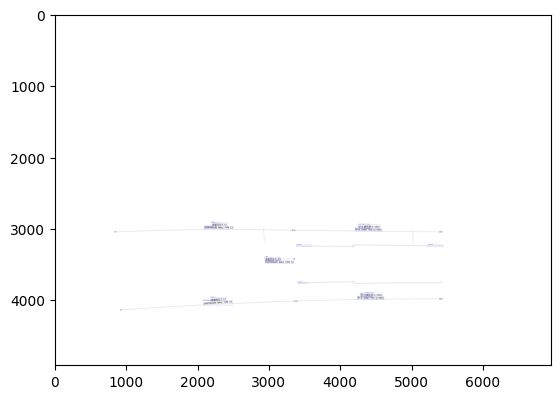

In [10]:
img = cv2.imread('plan_WordAndWall1.jpg')
ocr_result = draw_boxes(img,bounds)
plt.imshow(ocr_result)
cv2.imwrite("plan_WordAndWall1ocr.jpg", ocr_result)

In [123]:
print(bounds[0][0])

[[854, 631], [1166, 631], [1166, 688], [854, 688]]


arrow detection

In [3]:
# read image
img = cv2.imread("plan_WordAndWall1.jpg")

# Gray Scaling
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# cv2.imwrite('img_gray.png',img_gray)

# Multilevel Thresholding -- OTSU method
ret, th = cv2.threshold(img_gray , 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
cv2.imwrite('img_otsu.png',th)

# Morphological Operation -- Black Hat
filterSize =(2,2) # (4,4)for dpi = 300, (2,2) for dpi = 200 (6,6) for filter dpi=300
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, filterSize)

img_bhat = cv2.morphologyEx(th, cv2.MORPH_BLACKHAT, kernel)
cv2.imwrite('img_bhat.png', img_bhat)

# Substract Origin
img_invers = cv2.bitwise_not(th)
img_sub = img_invers - img_bhat
# cv2.imwrite('img_sub.png', img_sub)

# Additional Morphological Operations -- Erosion, Dilation 
kernel2 = np.ones((2, 2))
kernel3 = np.ones((4, 4))  # for dwg_output erode-1 
kernel4 = np.ones((3, 3))  # for big_arrow erode-1 dilate-2
kernel5 = np.ones((5, 5))  # for dwg_output dilate-2
kernel6 = np.ones((6, 6))

img_erode = cv2.erode(img_sub, kernel3, iterations=1)
cv2.imwrite('img_erode.png',img_erode)
# turn the pixel to 0 according to the ocr result
for i in range(len(bounds)):
    #bounds[i][0][0][0] = [x1, y1]
    #bounds[i][0][0][2] = [x2, y2]
    x1, y1 = bounds[i][0][0]
    x2, y2 = bounds[i][0][2]
    img_erode[y1:y2, x1:x2] = 0

img_dilate = cv2.dilate(img_erode, kernel5, iterations=2)
cv2.imwrite('img_dilate.png',img_dilate)

# Countors detection
contours, hierarchy = cv2.findContours(img_dilate, cv2.RETR_LIST , cv2.CHAIN_APPROX_NONE)

# for dwg case
# print(len(contours))
for i in range(len(contours)):
    x,y,w,h  = cv2.boundingRect(contours[i])
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,255),1)

# show and save image
cv2.imwrite('plan_arrowDetection1.jpg',img)
plt.imshow(img)

NameError: name 'bounds' is not defined

Line detection

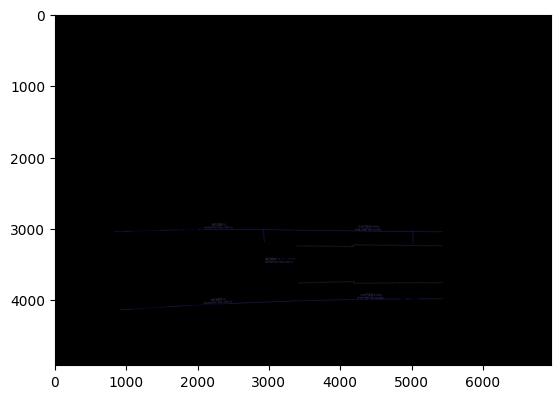

In [12]:
# line thinning
thinned = cv2.ximgproc.thinning(img_bhat)
# get all the lines in the image
lines = FLD(thinned, thinned)

In [13]:
def for_hori(bl, tr, p, thr) :
   if (p[0] > bl[0]-thr and p[0] < tr[0]+thr and p[1] > bl[1] and p[1] < tr[1]) :
      return True
   else :
      return False

def for_vert(bl, tr, p, thr) :
   if (p[0] > bl[0] and p[0] < tr[0] and p[1] > bl[1]-thr and p[1] < tr[1]+thr) :
      return True
   else :
      return False
   
import pandas as pd
df = pd.DataFrame(columns = ['left_arrow', 'right_arrow'],index = range(len(lines)))

# seperate two type of arrow
hori_arrow = []
vert_arrow = []
for i in range(len(contours)):
  x,y,w,h = cv2.boundingRect(contours[i])
  if w > h:
    hori_arrow.append(i)
  else:
    vert_arrow.append(i)

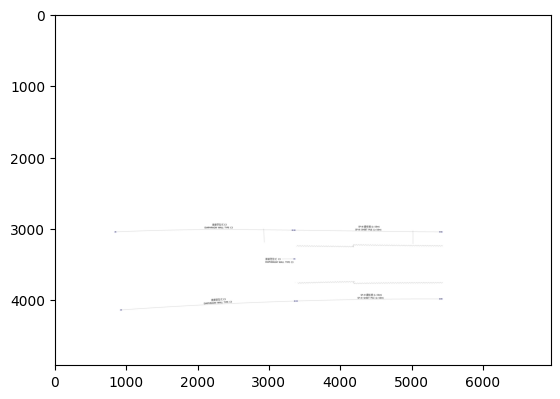

In [14]:
# draw img to check if the arrow is successfully seprated into hor and ver
img = cv2.imread("plan_WordAndWall1.jpg")
for i in hori_arrow:
  x,y,w,h = cv2.boundingRect(contours[i])
  cv2.rectangle(img,(x,y),(x+w,y+h),(0,0,255),1)
for i in vert_arrow:
  x,y,w,h = cv2.boundingRect(contours[i])
  cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),1)

plt.imshow(img)

In [15]:
check = []
# 記錄錯誤的雙線
for i in range(len(lines)):
  for j in range(len(lines)-(i+1)):
    line1 = lines[i]
    line2 = lines[i+j+1]
    # line1 is correct
    if float(line1[0,0]) < float(line1[0,2]) or float(line1[0,1] < float(line1[0,3])):
      if ((float(line1[0,0])-float(line2[0,2]))**2 + (float(line1[0,1])-float(line2[0,3]))**2)**(1/2) < 10 and ((float(line1[0,2])-float(line2[0,0]))**2 + (float(line1[0,3])-float(line2[0,1]))**2)**(1/2) < 3:
        check.append(i+j+1)
    # line1 is not correct
    else:
      if ((float(line1[0,0])-float(line2[0,2]))**2 + (float(line1[0,1])-float(line2[0,3]))**2)**(1/2) < 10 and ((float(line1[0,2])-float(line2[0,0]))**2 + (float(line1[0,3])-float(line2[0,1]))**2)**(1/2) < 3:
        check.append(i)

# seperate two type of line
hori_line = []
vert_line = []
for k, line in enumerate(lines):
  if k  not in check:
    if ((float(line[0,0])-float(line[0,2]))**2 + (float(line[0,1])-float(line[0,3]))**2)**(1/2) > 30:
      if (float(line[0,0])-float(line[0,2]))**2 > (float(line[0,1])-float(line[0,3]))**2:
        hori_line.append(k)
      else:
        vert_line.append(k)

In [16]:
# remove the line that the head coordinate is smaller than the tail coordinate
for i in hori_line:
    if float(lines[i][0,0]) > float(lines[i][0,2]):
        hori_line.remove(i)
print(hori_line)

[126, 132, 137, 138, 141, 142, 147, 148, 150, 151, 154, 156, 158, 160, 162, 163, 165, 168, 169, 171, 172, 174, 175, 177, 178, 180, 181, 183, 184, 186, 187, 190, 191, 194, 195, 200, 203, 206, 209, 212, 215, 218, 221, 224, 228, 232, 236, 239, 240, 243, 246, 387, 619, 623, 625, 626, 627, 628, 631, 633, 634, 635, 636, 637, 639, 640, 641, 642, 643, 644, 645, 646, 647, 648, 651, 652, 654, 657, 659, 660, 661, 662]


1


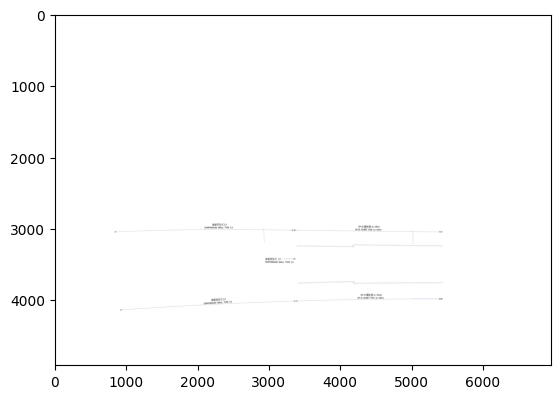

In [17]:
# checking horizional line with arrow
img = cv2.imread("plan_WordAndWall1.jpg")
count = 0
for i in hori_line:
  line = lines[i]
  p1 = (int(line[0,0]),int(line[0,1]))
  p2 = (int(line[0,2]),int(line[0,3]))
  for j in hori_arrow:
    x,y,w,h = cv2.boundingRect(contours[j])
    b1 = (x,y)
    tr = (x+w, y+h)
    # check left side
    if for_hori(b1, tr, p1, 2):
      count+=1
      cv2.line(img, p1, p2, [0, 0, 255], 1) 
      cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),1)
      # df.iat[i,0]= j
      df.loc[i,'left_arrow'] = j
    # check right side
    elif for_hori(b1, tr, p2, 3):
      # df.iat[i,1]= j
      df.loc[i,'right_arrow'] = j
      cv2.line(img, p1, p2, [0, 0, 255], 1) 
      cv2.rectangle(img,(x,y),(x+w,y+h),[255,0,0],1)

for i in vert_line:
  line = lines[i]
  p1 = (int(line[0,0]),int(line[0,1]))
  p2 = (int(line[0,2]),int(line[0,3]))
  for j in vert_arrow:
    x,y,w,h = cv2.boundingRect(contours[j])
    b1 = (x,y)
    tr = (x+w, y+h)
    # check left side
    if for_vert(b1, tr, p1, 3):
      df.iat[i,0]= j
      cv2.line(img, p1, p2, [0, 0, 255], 1) 
      cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),1)
    # check right side
    elif for_vert(b1, tr, p2, 3):
      df.iat[i,1]= j
      cv2.line(img, p1, p2, [0, 0, 255], 1) 
      cv2.rectangle(img,(x,y),(x+w,y+h),[255,0,0],1)

plt.imshow(img)
cv2.imwrite("plan_pair1.jpg", img)
print(count)

In [18]:
# drop out the one with no arrow paired
df_any = df.dropna(axis='index', how='any') # drop out if the line has no two arrows paired
df_all = df.dropna(axis='index', how='all') # drop out if the line has no any arrows paired

In [19]:
print(df_all)

    left_arrow right_arrow
169          7         NaN
387        NaN           4
623        NaN           3


In [22]:

word = 'SHEET PILE'
# image = Image.open('/content/input.png')
image = cv2.imread("plan_WordAndWall2.jpg")
count = 0
pair_array = []

for j, bound in enumerate(bounds):
  bound = list(bound)
  if (bound[1].upper()).find(word) > -1:
    dis = 1000000000
    middle_point = [(bounds[j][0][0][0] + bounds[j][0][2][0]) // 2,(bounds[j][0][0][1] + bounds[j][0][2][1]) // 2]
    check = 0
    for k in range(len(df_all)):
      line = lines[df_all.index[k]]
      p_mean = [ (int(line[0,0]) + int(line[0,2])) //2 , (int(line[0,1]) + int(line[0,3])) //2 ]
      if ((middle_point[0]-p_mean[0])**2 + (middle_point[1]-p_mean[1])**2) < dis:
        dis = (middle_point[0]-p_mean[0])**2 + (middle_point[1]-p_mean[1])**2
        check = df_all.index[k]
    pair_array.append([j,check])

print(pair_array)

[[3, 169], [12, 623]]


In [23]:
# plot the result using pair_array and df_all
img = cv2.imread("plan_WordAndWall1.jpg")
for text_index, line_index in pair_array:
  line = lines[line_index]
  p_mean = [ (int(line[0,0]) + int(line[0,2])) //2 , (int(line[0,1]) + int(line[0,3])) //2 ]
  p1 = (int(line[0,0]),int(line[0,1]))
  p2 = (int(line[0,2]),int(line[0,3]))
  if not pd.isnull(df_all.loc[line_index,'left_arrow']):
    x,y,w,h = cv2.boundingRect(contours[int(df_all.loc[line_index,'left_arrow'])])
    cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),1)
  if not pd.isnull(df_all.loc[line_index,'right_arrow']):
    x,y,w,h = cv2.boundingRect(contours[int(df_all.loc[line_index,'right_arrow'])])
    cv2.rectangle(img,(x,y),(x+w,y+h),[255,0,0],1)
  cv2.line(img, p1, p2, [0, 0, 255], 1)
  middle_point = [(bounds[text_index][0][0][0] + bounds[text_index][0][2][0]) // 2,(bounds[text_index][0][0][1] + bounds[text_index][0][2][1]) // 2]
  cv2.line(img, p_mean, middle_point, color=(0, 255, 0) , thickness=2)

cv2.imwrite("plan_result11111.jpg", img)

True

In [24]:
# output csv file 

index = list(range(len(pair_array)))

df = pd.DataFrame(np.arange((len(pair_array))*5).reshape(len(pair_array),5), columns=['head_x', 'head_y', 'end_x', 'end_y', 'ocr'],
                  index=index)
wall_type = []

for i in pair_array:
  indexx = i[0]
  string = bounds[indexx][1]
  wall_type.append(string)

for index,i in enumerate(pair_array): 
  text_index = i[0]
  line_index = i[1]
  line = lines[line_index]
  # if df index have left arrow use left arrow's x cooridnate
  if not pd.isnull(df_all.loc[line_index,'left_arrow']):
    x,y,w,h = cv2.boundingRect(contours[int(df_all.loc[line_index,'left_arrow'])])
    df.iloc[index,0] = x 
  else:
    df.iloc[index,0] = min(int(line[0,0]), int(line[0,2]))
  df.iloc[index,1] = min(int(line[0,1]), int(line[0,3]))
  
  # if df index have right arrow use right arrow's x cooridnate
  if not pd.isnull(df_all.loc[line_index,'right_arrow']):
    x,y,w,h = cv2.boundingRect(contours[int(df_all.loc[line_index,'right_arrow'])])
    df.iloc[index,2] = x + w
  else:
    df.iloc[index,2] = max(int(line[0,0]), int(line[0,2]))
  df.iloc[index,3] = max(int(line[0,3]), int(line[0,1]))

  df.iloc[index,4] = wall_type[index]

print(df)

   head_x  head_y  end_x  end_y                        ocr
0    3341    3025   3407   3025  SP-III SHEET PILE (L=l6m)
1    4983    3987   5424   3987  SP-III SHEET PILE (Lzl6m)


In [180]:
image = cv2.imread("plan_WordAndWall2.jpg")
for i in pair_array:
  middle_point = [(bounds[i[0]][0][0][0] + bounds[i[0]][0][2][0]) // 2,(bounds[i[0]][0][0][1] + bounds[i[0]][0][2][1]) // 2]
  line = lines[i[1]]
  p_mean = [ (int(line[0,0]) + int(line[0,2])) //2 , (int(line[0,1]) + int(line[0,3])) //2 ]
  image = cv2.line(image, p_mean, middle_point, color=(0, 255, 0) , thickness=3)
cv2.imwrite("plan_WordAndWall2_pairresult.jpg", image)

True

#### 用pdf抓線段

In [27]:
# turn pdf to jpg
path = "C:\\Users\\jimmy\\Desktop\\sinotech2\\data\\pdf\\SheetPile\\plan_OnlyWall1.pdf"
images = convert_from_path(path, dpi =210)
cv2_img = cv2.cvtColor(np.asarray(images[0]),cv2.COLOR_RGB2BGR)
img_gray = cv2.cvtColor(cv2_img, cv2.COLOR_BGR2GRAY)
_, img_th = cv2.threshold (img_gray, 240, 255, 0)
img = cv2.GaussianBlur(img_th, (5, 5), 0)

cv2.imwrite("plan_OnlyWall1.jpg", img)

True

In [28]:
# read image
img = cv2.imread("plan_OnlyWall1.jpg")

# Gray Scaling
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# cv2.imwrite('img_gray.png',img_gray)

# Multilevel Thresholding -- OTSU method
ret, th = cv2.threshold(img_gray , 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
# cv2.imwrite('img_otsu.png',th)

# Morphological Operation -- Black Hat
filterSize =(2,2) # (4,4)for dpi = 300, (2,2) for dpi = 200 (6,6) for filter dpi=300
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, filterSize)

img_bhat = cv2.morphologyEx(th, cv2.MORPH_BLACKHAT, kernel)
# cv2.imwrite('img_bhat.png', img_bhat)

# Substract Origin
img_invers = cv2.bitwise_not(th)
img_sub = img_invers - img_bhat
# cv2.imwrite('img_sub.png', img_sub)

# Additional Morphological Operations -- Erosion, Dilation 
kernel2 = np.ones((2, 2))
kernel1 = np.ones((1, 1))
kernel3 = np.ones((4, 4))  # for dwg_output erode-1 
kernel4 = np.ones((3, 3))  # for big_arrow erode-1 dilate-2
kernel5 = np.ones((5, 5))  # for dwg_output dilate-2
kernel6 = np.ones((6, 6))

img_erode = cv2.erode(img_sub, kernel1, iterations=2)
# cv2.imwrite('img_erode.png',img_erode)

img_dilate = cv2.dilate(img_erode, kernel6, iterations=2)
# cv2.imwrite('img_dilate.png',img_dilate)

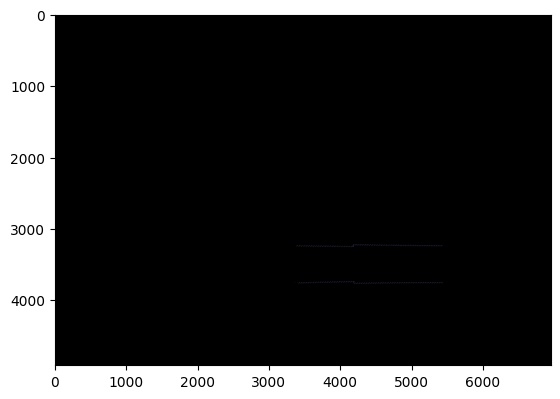

In [29]:
# line thinning
thinned = cv2.ximgproc.thinning(img_bhat)
# get all the lines in the image
lines = FLD(thinned, thinned)

In [30]:
# print(lines)
# output csv file
import pandas as pd
index = list(range(len(lines)))
df2 = pd.DataFrame(np.arange((len(lines))*4).reshape(len(lines),4), columns=['head_x', 'head_y', 'end_x', 'end_y'],
                    index=index)

for index,i in enumerate(lines):
    line = i
    df2.iloc[index,0] = int(line[0,0])
    df2.iloc[index,1] = int(line[0,1])
    df2.iloc[index,2] = int(line[0,2])
    df2.iloc[index,3] = int(line[0,3])

print(df2)
df2.to_csv("plan_OnlyWall1.csv")

     head_x  head_y  end_x  end_y
0      4188    3223   4178   3223
1      4208    3222   4203   3233
2      4222    3223   4210   3223
3      4241    3223   4235   3234
4      4255    3224   4243   3224
..      ...     ...    ...    ...
273    4273    3762   4262   3762
274    4193    3763   4189   3772
275    4207    3763   4195   3763
276    4196    3765   4206   3765
277    4510    3770   4520   3770

[278 rows x 4 columns]


In [31]:
def group_by_y_and_connect_extremes(lines, y_threshold=100):
    """Group lines based on y-coordinate and connect the leftmost and rightmost lines in each group."""
    # Sort lines by the average y-coordinate
    lines.sort(key=lambda x: (x[1] + x[3]) / 2)

    # Group lines by y-coordinate with a difference threshold
    grouped_lines = []
    current_group = [lines[0]]

    for line in lines[1:]:
        if abs(((line[1] + line[3]) / 2) - ((current_group[-1][1] + current_group[-1][3]) / 2)) > y_threshold:
            grouped_lines.append(current_group)
            current_group = [line]
        else:
            current_group.append(line)
    
    if current_group:
        grouped_lines.append(current_group)

    # For each group, find the leftmost and rightmost line and connect them
    connected_lines = []
    for group in grouped_lines:
        if len(group) == 1:
            connected_lines.append((group[0][0], group[0][1], group[0][2], group[0][3]))
            continue
        # Find the leftmost and rightmost lines
        leftmost = min(group, key=lambda x: min(x[0], x[2]))
        rightmost = max(group, key=lambda x: max(x[0], x[2]))
        # Connect the leftmost start to the rightmost end
        connected_lines.append((min(leftmost[0], leftmost[2]), 
                                (leftmost[1] + leftmost[3]) / 2, 
                                max(rightmost[0], rightmost[2]), 
                                (rightmost[1] + rightmost[3]) / 2))

    return connected_lines

def segment_main_lines_with_labels(connected_lines_by_y, ocr_data):

    # Extract the bounds for the upper and lower lines
    upper_bounds = (connected_lines_by_y[0][0], connected_lines_by_y[0][2])
    lower_bounds = (connected_lines_by_y[1][0], connected_lines_by_y[1][2])

    # Determine the mid y-coordinates of upper and lower lines
    upper_mid_y = (connected_lines_by_y[0][1] + connected_lines_by_y[0][3]) / 2
    lower_mid_y = (connected_lines_by_y[1][1] + connected_lines_by_y[1][3]) / 2
    
    # Function to determine the closest main line based on y-coordinate
    def closest_main_line(y_coord):
        if abs(y_coord - upper_mid_y) < abs(y_coord - lower_mid_y):
            return 'upper'
        else:
            return 'lower'
    
    # Assign lines to upper or lower based on y-coordinate
    ocr_data['line_group'] = ocr_data.apply(lambda row: closest_main_line((row['head_y'] + row['end_y']) / 2), axis=1)

    # Extract segments for upper and lower lines
    segments_upper = ocr_data[ocr_data['line_group'] == 'upper'][['head_x', 'end_x', 'ocr']]
    segments_lower = ocr_data[ocr_data['line_group'] == 'lower'][['head_x', 'end_x', 'ocr']]

    # Segmenting logic as previously defined
    def correct_segment_main_line(bounds, segments):
        line_segments = []
        start, end = bounds
        sorted_segments = sorted(segments, key=lambda x: x['head_x'])

        # Initialize the previous end to the start of the main line
        prev_end = start

        # Iterate through sorted segments and ensure no overlap
        for segment in sorted_segments:
            current_start = max(prev_end, segment['head_x'])  # Start at the greater of previous end or current head_x
            current_end = segment['end_x']
            
            # If there's a gap between the previous end and the current start, fill it with the previous segment's label
            if current_start > prev_end:
                line_segments.append((prev_end, current_start, segment['ocr']))  # Use the first segment's label for any initial gap
            
            # Append the current segment
            line_segments.append((current_start, current_end, segment['ocr']))
            prev_end = current_end  # Update the previous end

        # Handle any remaining portion of the main line after the last segment
        if prev_end < end:
            line_segments.append((prev_end, end, sorted_segments[-1]['ocr']))  # Use the last segment's label for the final gap

        return line_segments

    # Segmenting the upper and lower lines
    segmented_upper = correct_segment_main_line(upper_bounds, segments_upper.to_dict('records'))
    segmented_lower = correct_segment_main_line(lower_bounds, segments_lower.to_dict('records'))

    # Combine and return segmented data
    segmented_data = {'upper': segmented_upper, 'lower': segmented_lower}
    return segmented_data

In [32]:
lines_list = []
for line in lines:
    x1, y1, x2, y2 = line[0]
    lines_list.append([x1, y1, x2, y2])

In [110]:
print(lines_list)

[[596.7847, 907.88965, 590.86334, 919.4425], [610.0, 908.0, 598.0, 908.0], [629.8116, 908.89276, 623.7985, 919.4546], [643.0, 909.0, 631.0, 909.0], [662.67615, 908.8445, 657.6491, 919.3117], [676.0, 909.0, 664.0, 909.0], [695.67615, 908.8445, 690.6491, 919.3117], [709.0, 909.0, 697.0, 909.0], [728.67615, 908.8445, 723.6491, 919.3117], [742.0, 909.0, 730.0, 909.0], [762.62823, 908.7826, 756.4865, 919.28455], [775.0, 909.0, 764.0, 909.0], [795.40857, 909.2584, 788.8908, 919.5634], [808.0, 909.0, 797.0, 909.0], [828.6287, 908.80774, 822.6562, 920.33984], [841.0, 909.0, 830.0, 909.0], [861.6287, 908.80774, 855.6562, 920.33984], [874.0, 909.0, 863.0, 909.0], [927.6882, 908.83856, 921.71796, 920.37164], [599.0, 910.0, 609.0, 910.0], [894.6392, 909.7933, 888.59485, 920.3409], [907.0, 910.0, 896.0, 910.0], [960.76184, 909.8637, 954.72296, 920.4138], [973.0, 910.0, 962.0, 910.0], [993.76184, 909.8637, 987.72296, 920.4138], [1006.0, 910.0, 995.0, 910.0], [1026.8113, 909.8926, 1020.79877, 920.454

In [33]:
connected_lines_sample = group_by_y_and_connect_extremes(lines_list)
segmented_data = segment_main_lines_with_labels(connected_lines_sample, df)

In [34]:
for i in segmented_data['upper']:
    print(i)

print("-----------------------------------")

for i in segmented_data['lower']:
    print(i)

(3383.6492, 3407, 'SP-III SHEET PILE (L=l6m)')
(3407, 5418.0, 'SP-III SHEET PILE (L=l6m)')
-----------------------------------
(3402.9558, 4983, 'SP-III SHEET PILE (Lzl6m)')
(4983, 5424, 'SP-III SHEET PILE (Lzl6m)')


In [35]:
import re

plan_wall_img= cv2.imread("plan_WordAndWall1.jpg")

# Extract the length value from the OCR text and create a color mapping based on unique length values
length_pattern = re.compile(r"L[=z](\d+)m")

def extract_length(text):
    match = length_pattern.search(text.replace('l', '1'))  # Replace possible 'l' with '1' for consistency
    return int(match.group(1)) if match else None

# Update the segments data to include length values
df['length'] = df['ocr'].apply(extract_length)
unique_lengths = df['length'].unique()
# Plotting segmented lines with their labels
colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255), (255, 255, 0), (0, 255, 255), (255, 0, 255)]
color_map = {length: color for length, color in zip(unique_lengths, colors[:len(unique_lengths)])}

# Visualization function updated to use length-based colors
def plot_segmented_lines_by_length(segments, connected_lines_sample):
    for keys in segments.keys():
        for segment in segments[keys]:
            if keys == 'upper':
                y_level = connected_lines_sample[0][1]
            else:
                y_level = connected_lines_sample[1][1]
            length = segment[2].split(' ')[-1]
            color = color_map[extract_length(segment[2])]
            cv2.line(plan_wall_img, (int(segment[0]), int(y_level)), (int(segment[1]), int(y_level)), color, 2)
            mid_x = int((segment[0] + segment[1]) // 2)
            cv2.putText(plan_wall_img, length, (mid_x, int(y_level)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
    cv2.imwrite('plan_OnlyWall1_segmented.jpg', plan_wall_img)

plot_segmented_lines_by_length(segmented_data, connected_lines_sample)

In [36]:
distance1 = (5418 - 3383.6492)*15/620
distance2 = (5424 - 3402.9558)*15/620
print(distance1+distance2)

98.11439516129032
